<a href="https://colab.research.google.com/github/sametaydn/Brain-Cancer-Detection/blob/main/BrainCancerClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import os
from os import environ
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
import tensorflow as tf
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
import PIL.Image
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
from IPython.display import display, Image
from tkinter import *
from PIL import ImageTk, Image


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from zipfile import ZipFile
file_name = "braindata.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')


Done


In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
#tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Dense, Dropout,Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping 

In [ ]:
# Creating dataframe by iterating through filepaths
tumor_dir=r'/content/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor'
healthy_dir=r'/content/Brain Tumor Data Set/Brain Tumor Data Set/Healthy'
filepaths = []
labels= []
dict_list = [tumor_dir, healthy_dir]
for i, j in enumerate(dict_list): 
    flist=os.listdir(j)
    for f in flist:
        fpath=os.path.join(j,f)
        filepaths.append(fpath)
        if i==0:
          labels.append('cancer')
        else:
          labels.append('healthy') 
    
Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
tumor_data = pd.concat([Fseries,Lseries], axis=1)
tumor_df = pd.DataFrame(tumor_data)
print(tumor_df.head())
print(tumor_df["labels"].value_counts())

                                           filepaths  labels
0  /content/Brain Tumor Data Set/Brain Tumor Data...  cancer
1  /content/Brain Tumor Data Set/Brain Tumor Data...  cancer
2  /content/Brain Tumor Data Set/Brain Tumor Data...  cancer
3  /content/Brain Tumor Data Set/Brain Tumor Data...  cancer
4  /content/Brain Tumor Data Set/Brain Tumor Data...  cancer
cancer     2513
healthy    2087
Name: labels, dtype: int64


We have 4600 images, cancer and healthy brain MRI.

In [ ]:
#shape of datatset
tumor_df.shape

(4600, 2)

We split train and test parts which test size 30%.
Random_size = 42 is random number but it is the most frequently used number.
Then remained 70% train set split for 20% validation.

In [ ]:
#splitting data
train_images, test_images = train_test_split(tumor_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(tumor_df, test_size=0.2, random_state=42)

Shapes of train, test and validation parts. 

In [ ]:
#shape of splitted data
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(3680, 2)
(1380, 2)
(920, 2)
(3220, 2)


Data Augmentation, Crop, flip, zoom etc. to the data in our dataset. It is a technique that allows us to increase the amount of data by applying transactions. By expanding our dataset, we are helping to better train the model.

Data augmentation eliminates the overfitting problem of the model!

Our data is RGB data. Size 244x244, batch_size is 32 as default. Larger batch sizes can decrease model accuracy. 

class_mode: One of "categorical", "binary", "sparse", "input", or None. Default: "categorical". Determines the type of label arrays that are returned: - "categorical" will be 2D one-hot encoded labels

In [ ]:
#Generate batches of tensor image data with real-time data augmentation.
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #Used for Sequential Model
                                      batch_size=32,
                                      shuffle=False           
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 3680 validated image filenames belonging to 2 classes.
Found 1380 validated image filenames belonging to 2 classes.
Found 920 validated image filenames belonging to 2 classes.


We can simply get a dictionary from the DirectoryIterator containing both the labels and the index in the one-hot encoding. Accessing the keys will then give you all the labels.

In [ ]:
classes=list(train.class_indices.keys())
print (classes)

['cancer', 'healthy']


...

In [ ]:
def show_brain_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator 
    plt.figure(figsize=(16,16))
    length = len(labels)
    r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="blue",fontsize=16)
        plt.axis('off')
    plt.show()

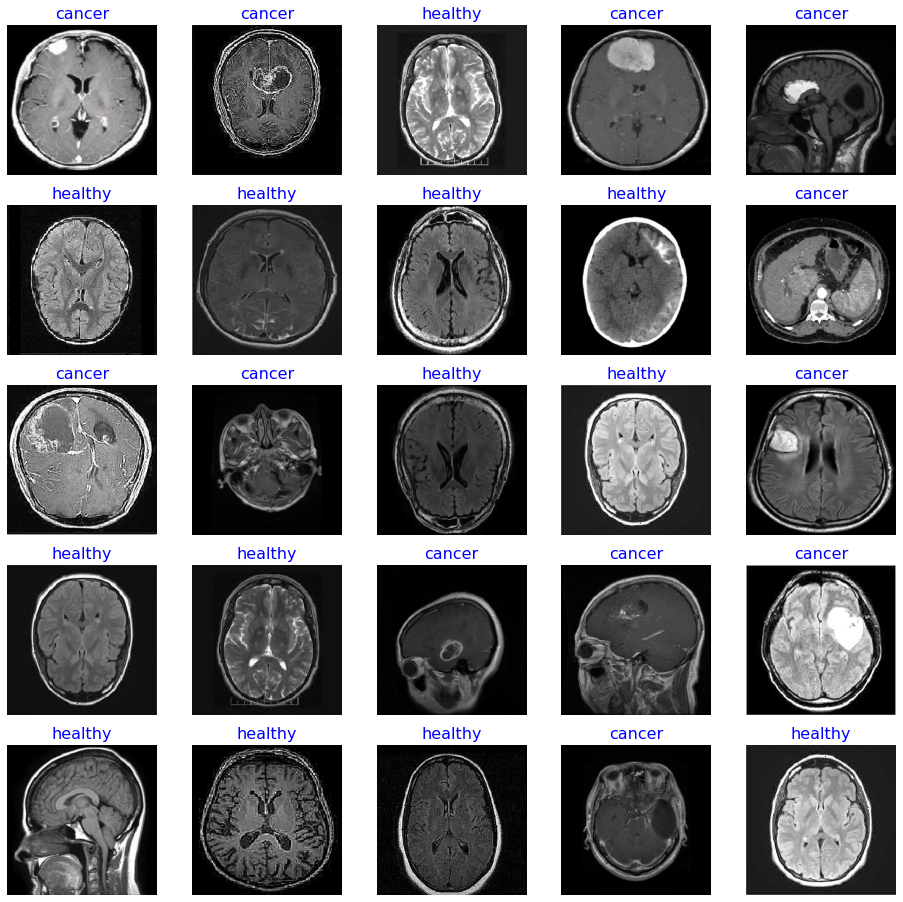

In [ ]:
show_brain_images(train)

Model Training

A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.

Filters is 32 to keep the high accuarcy. Tried kernel size 3x3 and 2x2 sequentially and 2x2 has more accuracy. (98.04 -> 98.7)
We chose "relu"(Rectified Linear Unit) activation function. It's used to produce this layer's output. "relu" is the most widely used activaion function and is good for performance because it's easy to calculate. That's why it is commely recommended.

Default padding is valid, which means no zero-padding, and the default strides is (1,1)

A pooling layer compresses (or down-samples) the results by discarding features, which helps make the model more general. The most common pooling technique is called max pooling, which examines a 2-by-2 square of features and keeps only the maximum feature.

To prepare for the one-dimensional final predictions, we first need to flatten the previous layer’s three-dimensional output. A Keras Flatten layer reshapes its input to one dimension. 

Dense layer is the regular deeply connected neural network layer. It is most common and frequently used layer. Dense layer does the below operation on the input and return the output.

Dense Layer is used to classify image based on output from convolutional layers.
This function is used to create fully connected layers, in which every output depends on every input.

In dropout section, it eliminates 30% of neurons to prevent overfitting.

The optimizer this model will use to adjust the weights throughout the neural network as it learns. 
There are many optimizers59— 'adam' performs well across a wide variety of models.

For binary classification Keras provides 'binary_crossentropy' and metrics=['accuracy']—This is a list of the metrics that the network will pro- duce to help you evaluate the model. Accuracy is a commonly used metric in clas- sification models.


In [ ]:
#Defining Sequential Model
model = Sequential() #Class
#Defining conv-pool layer
model.add(Conv2D(filters=32,kernel_size=(2,2),strides=(1,1), activation="relu", padding="valid",input_shape=(244,244,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

#Adding flatten layer
model.add(Flatten())

#Adding dense layers with dropout
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(64, activation="relu"))

#Output layer
model.add(Dense(2, activation="sigmoid")) #Sigmoid is used for binary.(0-healthy 1-cancer) Use Softmax for Mutliclass.


model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
#Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 243, 243, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 121, 121, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 468512)            0         
                                                                 
 dense (Dense)               (None, 128)               59969664  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                        

In [ ]:
#fitting model
History = model.fit(train, validation_data= val, epochs=10,verbose=1)

Epoch 1/10
115/115 [==============================] - 28s 142ms/step - loss: 1.7108 - accuracy: 0.7106 - val_loss: 0.3805 - val_accuracy: 0.8576
Epoch 2/10
115/115 [==============================] - 16s 141ms/step - loss: 0.3230 - accuracy: 0.8709 - val_loss: 0.1929 - val_accuracy: 0.9304
Epoch 3/10
115/115 [==============================] - 17s 149ms/step - loss: 0.2125 - accuracy: 0.9231 - val_loss: 0.1243 - val_accuracy: 0.9641
Epoch 4/10
115/115 [==============================] - 16s 139ms/step - loss: 0.1246 - accuracy: 0.9598 - val_loss: 0.0973 - val_accuracy: 0.9674
Epoch 5/10
115/115 [==============================] - 16s 139ms/step - loss: 0.1110 - accuracy: 0.9603 - val_loss: 0.0897 - val_accuracy: 0.9652
Epoch 6/10
115/115 [==============================] - 16s 138ms/step - loss: 0.0780 - accuracy: 0.9755 - val_loss: 0.0730 - val_accuracy: 0.9728
Epoch 7/10
115/115 [==============================] - 16s 138ms/step - loss: 0.0508 - accuracy: 0.9834 - val_loss: 0.0701 - val_ac

Text(0.5, 1.0, 'Training and Validation Accuracy')

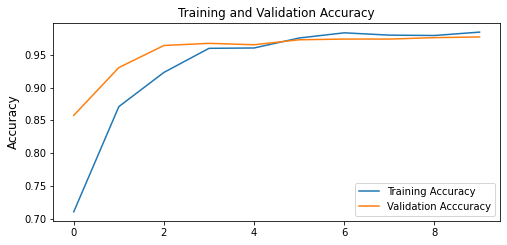

In [ ]:
acc = History.history["accuracy"] # Report of model
val_acc = History.history["val_accuracy"] # History of validation data

loss = History.history["loss"]        # Training loss
val_loss = History.history["val_loss"] # Validation loss

plt.figure(figsize=(8,8))
plt.subplot(2,1,1) # 2 rows and 1 columns
#Plotting respective accuracy
plt.plot(acc,label="Training Accuracy")
plt.plot(val_acc, label="Validation Acccuracy")

plt.legend()
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training and Validation Accuracy", fontsize=12)

Text(0.5, 1.0, 'Training and Validation Losses')

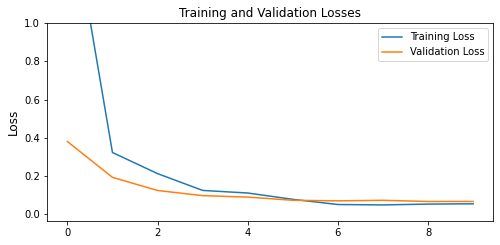

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
 
plt.plot(loss, label="Training Loss")      #Training loss
plt.plot(val_loss, label="Validation Loss") # Validation Loss

plt.legend()
plt.ylim([min(plt.ylim()),1])
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Losses", fontsize=12)

In [ ]:
model.evaluate(test, verbose=1)

44/44 [==============================] - 5s 103ms/step - loss: 0.0463 - accuracy: 0.9848


[0.04633527621626854, 0.9847826361656189]

In [ ]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

In [ ]:
y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:",accuracy_score(y_test, pred2)*100,"%")

              precision    recall  f1-score   support

      cancer       0.99      0.98      0.99       779
     healthy       0.98      0.99      0.98       601

    accuracy                           0.98      1380
   macro avg       0.98      0.99      0.98      1380
weighted avg       0.98      0.98      0.98      1380

Accuracy of the Model: 98.47826086956522 %


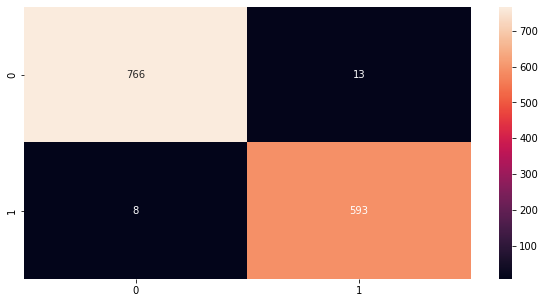

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize = (10,5))
cm = confusion_matrix(y_test, pred2)
sns.heatmap(cm, annot=True, fmt = 'g')
#cmap='Greens'


-------------------------------------------------------------------------------
**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [ ]:
def img_pred(uploader):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(244,244))
    img = img.reshape(1,244,244,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        print('\tCancer')
    elif p==1:
        print('\tHealthy')
    else:
        p=='NOT SURE'


In [ ]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

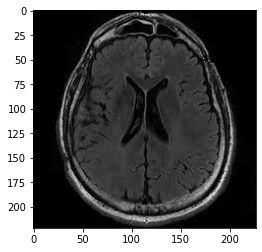

In [ ]:
from PIL import Image

for name, file_info in uploader.value.items():
  img3 = Image.open(io.BytesIO(file_info['content']))
  img3.show(title=None, command=None)
  plt.imshow(img3)
  

button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
            
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])




In [ ]:
print(uploader)

FileUpload(value={'Cancer (21).jpg': {'metadata': {'name': 'Cancer (21).jpg', 'type': 'image/jpeg', 'size': 21577, 'lastModified': 1621149642000}, 'content': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x03\x02\x02\x02\x02\x02\x03\x02\x02\x02\x03\x03\x03\x03\x04\x06\x04\x04\x04\x04\x04\x08\x06\x06\x05\x06\t\x08\n\n\t\x08\t\t\n\x0c\x0f\x0c\n\x0b\x0e\x0b\t\t\r\x11\r\x0e\x0f\x10\x10\x11\x10\n\x0c\x12\x13\x12\x10\x13\x0f\x10\x10\x10\xff\xdb\x00C\x01\x03\x03\x03\x04\x03\x04\x08\x04\x04\x08\x10\x0b\t\x0b\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\xff\xc0\x00\x11\x08\x02\x00\x02\x00\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1d\x00\x01\x00\x01\x05\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x03\x04\x05\x06\x07\x08\t\x01\xff\xc4\x00F\x10\x00\x01\x03\x03\x02\x04\x04\x04\x03\x06\x